2023-03-07 15:04:13.181568: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 15:04:13.287704: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 15:04:13.312465: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-07 15:04:13.764238: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

GPUS: []
vmaf -r /home/nwaliv/MAIProject-main/processing/patchesRef.yuv -d /home/nwaliv/MAIProject-main/processing/patchesDeg.yuv -w 384 -h 384 -p 420 -b 8 --csv -o /home/nwaliv/MAIProject-main/processing/scores.csv --feature cambi
(4, 192, 192, 1)


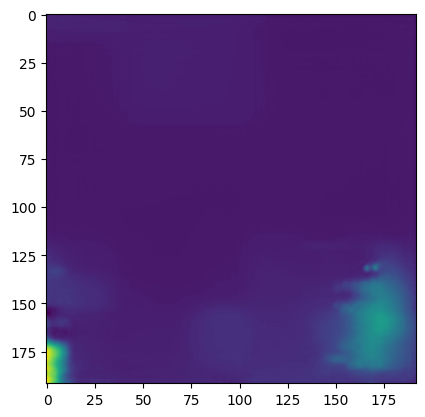

[[ 9.706821]
 [ 4.22386 ]
 [19.487017]
 [ 6.693904]]
(4, 1)


SyntaxError: 'break' outside loop (24379221.py, line 138)

In [1]:
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_addons as tfa 
import os 
from library import * 
from library.GeneralOps import readYUV420, YUV2RGB, RGB2YUV_TF, readYUV420RangePatches
from library.CriticModel import ProxyNetwork
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random 
import json 

patchSize = 192
modelName = 'CRITIC_MSE'


outputJson = f'results/{modelName}.json'
# the generator model will be hrNet
generator = hrNet(2, [32, 64, 128, 256], 5).model()
generator.load_weights('results/HRNET_MSE.h5')
# Read in the proxy network for CAMBI
critic = ProxyNetwork().model()
# Define the optimizers and loss function
optimizerCritic = keras.optimizers.RMSprop(learning_rate=1e-4)
#optimizerGenerator = keras.optimizers.RMSprop(learning_rate=1e-4)
EPOCHS = 100
LossFunc = keras.losses.MeanSquaredError()
#train_metric_gen_mse = keras.metrics.MeanSquaredError()
train_metric_critic = keras.metrics.MeanSquaredError()
#train_metric_gen_vmaf = keras.metrics.MeanSquaredError()

print(f"GPUS: {tf.config.list_physical_devices('GPU')}")

# # Define the training functions
# @tf.function
# def train_step_gen(_x, _y):
#     # _x is the degraded image, _y is the reference image
#     with tf.GradientTape() as tape:
#         # Generate the prediction
#         _genPred = generator([_x], training=True)
#         _genLoss = LossFunc(_genPred, _y)
#     # Apply the gradients to the generator
#     grads = tape.gradient(_genLoss, generator.trainable_weights)
#     optimizerGenerator.apply_gradients(zip(grads, generator.trainable_weights))
#     return _genPred

@tf.function
def run_gen(_x):
    _genOut = generator([_x], training=False)
    return _genOut

@tf.function
def train_step_critic(_x, _score,_genPred):
    # _yLuma is the luma of the reference image, _score is the critic score for the prediction, _genPredLuma is the luma of the prediction
    with tf.GradientTape() as tape:
        # Get the critic score for the prediction
        _pred = critic([_yLuma, _genPredLuma], training=True)
        # _pred = returnMetric
        # Define the loss function for the critic as the MSE between the critic score and the prediction
        _loss = LossFunc(_pred, _score)
    # Apply the gradients to the critic
    grads = tape.gradient(_loss, critic.trainable_weights)
    optimizerCritic.apply_gradients(zip(grads, critic.trainable_weights))
    return _pred

# DATAFRAME
BATCHSIZE = 4
# read in the training data
DATAFRAME = pd.read_csv('dataFrames/trainVideoSet_perframeCambi_maxFrame.csv')
DATAFRAME = DATAFRAME[DATAFRAME['FrameNum'] != 0]
DATAFRAME = DATAFRAME[DATAFRAME['FrameNum'] != DATAFRAME['MaxFrame']]
DATAFRAME = DATAFRAME.reset_index(drop=True)

baseRefPath = '/data/nwaliv/trainVideoSetRef/'
baseCompPath = '/data/nwaliv/trainVideoSetDeg/'

Loss = {'MSELoss' : []}

# the training loop
for _epoch in range(EPOCHS):
    # shuffle the dataframe
    indexes = np.arange(0, DATAFRAME.shape[0], 1)
    np.random.shuffle(indexes)
    _df = DATAFRAME.iloc[indexes].copy()
    # get the number of steps
    numSteps = _df.shape[0]//BATCHSIZE
    for step in range(numSteps): 
        # get the batch
        SAMPLE = _df.sample(n=BATCHSIZE, replace=False)
        _df = _df.drop(index=SAMPLE.index.tolist())
        SAMPLE = SAMPLE.reset_index(drop=True)
        # initialize the input and target arrays
        X_in = np.zeros((BATCHSIZE, patchSize, patchSize, 9))
        Y_target = np.zeros((BATCHSIZE, patchSize, patchSize, 3))
        scores = np.zeros((BATCHSIZE))
        # loop through the batch
        for idx, _row in SAMPLE.iterrows():
            # get height/width of original video
            _height = _row['Height']
            _width = _row['Width']
            _frameNum = _row['FrameNum']
            _comp = os.path.join(baseCompPath, _row['Comp'])
            _ref = os.path.join(baseRefPath, _row['Ref'])
            
            # generate random patch location 
            randHeight = np.random.randint(0,_height-patchSize)
            randWidth = np.random.randint(0,_width-patchSize)
            _xY, _xU, _xV = readYUV420RangePatches(_comp,(_width,_height),(_frameNum-1,_frameNum+1),(randWidth,randHeight),(patchSize,patchSize),True)
            _xYUV = np.stack([_xY, _xU, _xV], -1)
            _xRGB = YUV2RGB(_xYUV)/255.0

            _yY, _yU, _yV = readYUV420RangePatches(_ref,(_width,_height),(_frameNum,_frameNum),(randWidth,randHeight),(patchSize,patchSize),True)
            _yYUV = np.stack((_yY,_yU,_yV),axis=-1)
            _yRGB = YUV2RGB(_yYUV)/255.0

            _xRGB = np.concatenate((_xRGB[0], _xRGB[1], _xRGB[2]), axis=-1).reshape(1,patchSize,patchSize,9)

            # add the data to the arrays
            X_in[idx] = _xRGB[0]
            Y_target[idx] = _yRGB[0]
        X_in, Y_target = X_in.astype(np.float32), Y_target.astype(np.float32)

        # train the generator
        _genPred = run_gen(X_in)
        _genPred = tf.clip_by_value(_genPred, 0, 1)
        _genPredYUV = RGB2YUV_TF(_genPred)
        _genPredLuma = tf.expand_dims(_genPredYUV[...,0],-1)
        _genPredTiled, Y_targetTiled = upSample2XTile(_genPred), upSample2XTile(Y_target)
        _proxyTarget = returnMetric(_genPredTiled, Y_targetTiled, height=patchSize*2, width=patchSize*2)
        print(_genPredLuma.shape)
        plt.imshow(_genPredLuma[0,:,:,0])
        plt.show()
        print(_proxyTarget)
        print(_proxyTarget.shape)

    #     train_metric_gen_mse.update_state(_genPred, Y_target)

    #     if step % 1000 == 0:
    #         print(f'Epoch: {_epoch}, Step: {step}, MSE: {train_metric_gen_mse.result()}')
    # Loss['MSELoss'].append(float(train_metric_gen_mse.result()))
    # train_metric_gen_mse.reset_states()

# critic.save_weights(f'results/{modelName}.h5')

# with open(outputJson, "w") as outfile:
#     json.dump(Loss, outfile)